In [39]:
%matplotlib notebook

In [1]:
import numpy as np
import pandas as pd
import pymar
import multiprocess as mp
import time
import matplotlib.pyplot as plt
import utils
from scipy import integrate
import constants
import json
import plotters

## 1. Study Potential Energy Curves

Before we run the trajectory, we should examine the potential functions describing the 3 potential molecules. Since we calculated the energy spectrum of H2, we can also plot the energy level.

<IPython.core.display.Javascript object>


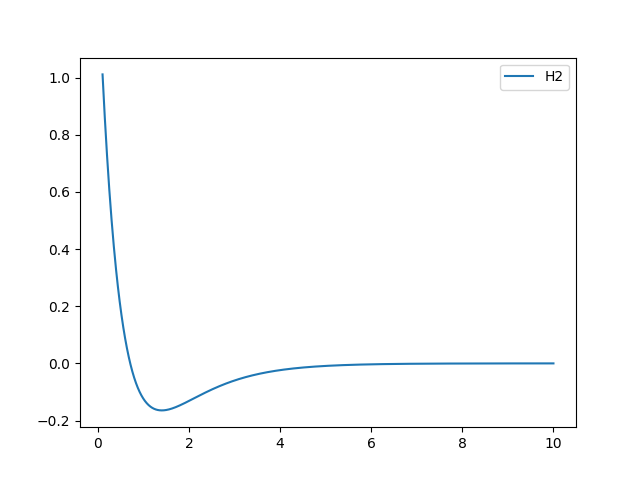

<IPython.core.display.Javascript object>


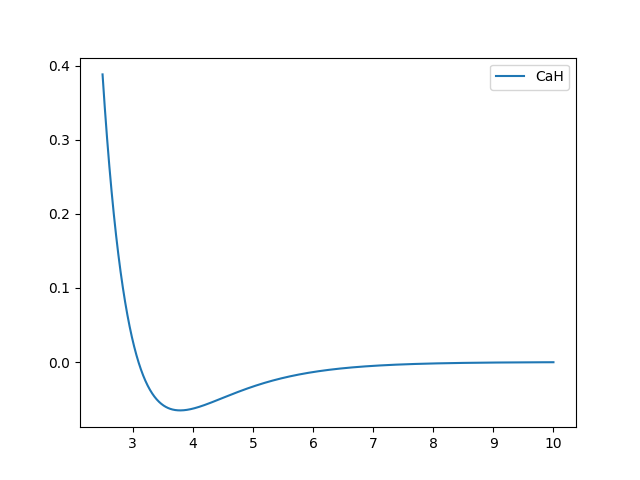

<IPython.core.display.Javascript object>


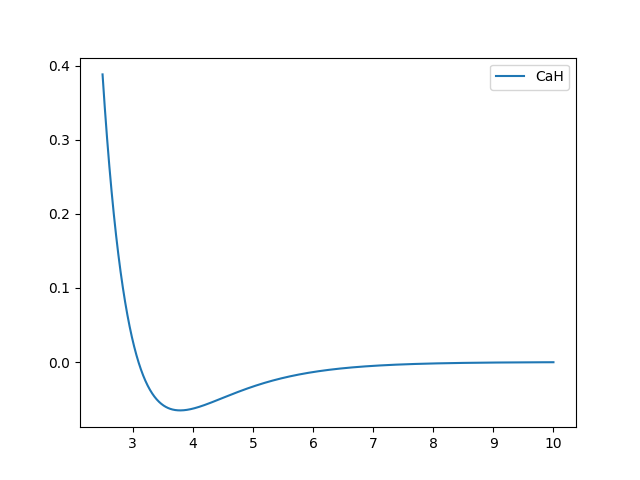

In [43]:
# Load input file
with open('inputs.json','r') as f:
    data = json.load(f)
mol1 = data['potential_params']["AB"][f"morse"]
mol2 = data['potential_params']["BC"][f"morse"]
mol3 = data['potential_params']['CA'][f'morse']
vF = pymar.Potential()
v1, dv1 = vF.morse(**mol1)
v2, dv2 = vF.morse(**mol2)
v3, dv3 = vF.morse(**mol3)
x1 = np.linspace(.1, 10, 1000)
x3 = np.linspace(2.5, 10, 1000)
x2 = np.linspace(2.5, 10, 1000)
plt.figure(1)
plt.plot(x1, v1(x1), label = 'H2')
plt.legend()
plt.figure(2)
plt.plot(x2, v2(x2), label = 'CaH')
plt.legend()
plt.figure(3)
plt.plot(x3, v3(x3), label = 'CaH')
plt.legend()


After defining the potential surfaces, we need to calculate the energy spectrum of the initial molecule ($H_2$).

[-0.15522923 -0.13737358 -0.12060856 -0.10493415 -0.09035035]


<IPython.core.display.Javascript object>


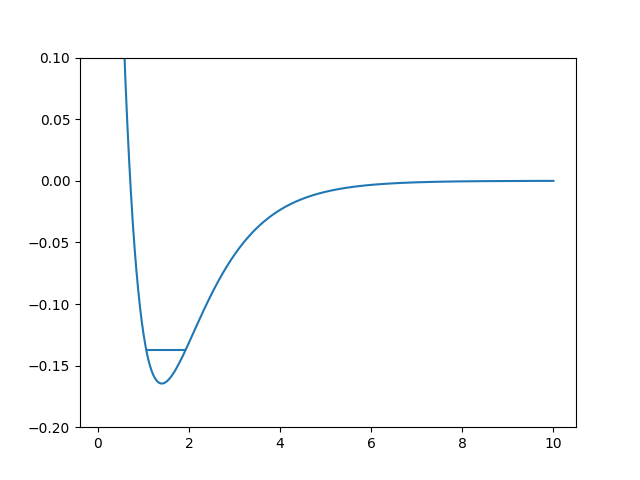

In [44]:
# Energy spectrum of H2
with open('inputs.json') as f:
    data = json.load(f)
m1,m2,m3 = data['masses'].values()
m12 = 1/(1/m1 + 1/m2)
pot_data = data['potential_params']["AB"]
h2 = pymar.Energy(mu=m12, npts=pot_data['npts'], xmin = pot_data['xmin'],
                xmax = pot_data['xmax'], j = data['ji'])
elev = h2.eDVR(v1)
h2.turningPts(v1,mol1['re'], v= data['vi'])
print(elev[:5])
plt.plot(x1, v1(x1))
plt.hlines(elev[data['vi']], h2.rm, h2.rp)
plt.ylim(-.2, .1)
plt.show()

# Run one trajectory
First, create the QCT calculation input dictionary using the start function, with the input file as the argument.

In [2]:
calc = pymar.start('inputs.json') # Create QCT calculation inputs

We can run a trajectory and obtain an output by running main(\**calc).

<IPython.core.display.Javascript object>


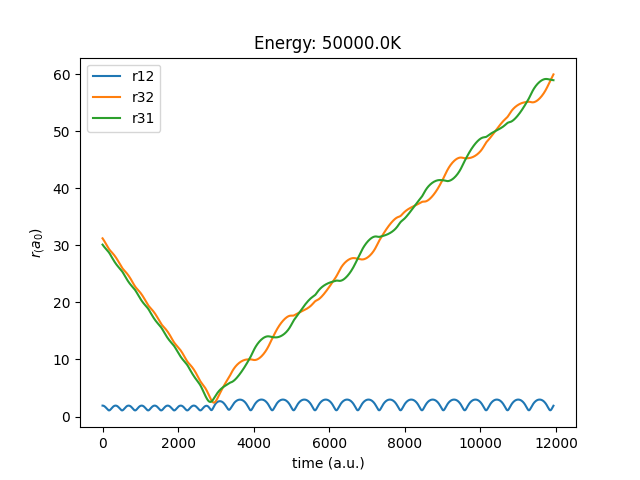

<IPython.core.display.Javascript object>


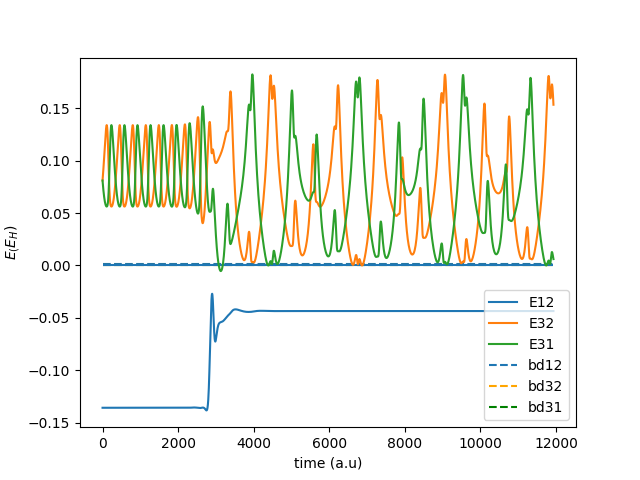

<IPython.core.display.Javascript object>


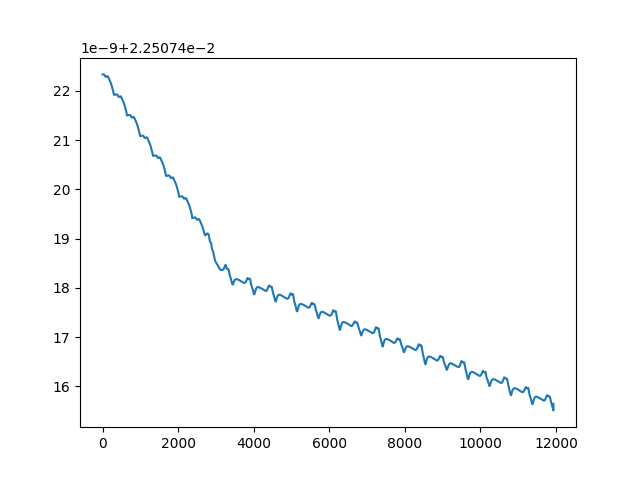

{'e': 50000.0,
 'b': 0,
 'h2': 1,
 'cah1': 0,
 'cah2': 0,
 'diss': 0,
 'v': 4.0,
 'w': 0.0005245205865823325,
 'j': 14.0,
 'd_i': 30.688273137280493,
 'theta': 0.9562611897469432,
 'phi': 2.79982224627231,
 'eta': 5.344771949206624,
 'n_i': 1.0,
 'j_i': 0,
 'rho1x': -1.5809609597801642,
 'rho1y': 0.5623953471447608,
 'rho1z': 0.866089975223896,
 'rho2x': -1.5809609597801642,
 'rho2y': 0.5623953471447608,
 'rho2z': 0.866089975223896,
 'p1x': -5.604248435552383,
 'p1y': 1.993599667910984,
 'p1z': 11.743861932404625,
 'tf': 11931.681809622572}

In [48]:
pymar.main(plot = True,**calc)

To track specific attributes, we can define a QCT object and run a trajectory on it. Following the `main()` function, first create a QCT object, then run the trajectory. To see a plot of the trajectory, set `doplot=True`.

In [3]:
# Run a trajectory until we get dissociation.
diss = pymar.QCT(**calc)
diss.runT()
i = 0
while diss.count[3] == 0 and i < 15:
    diss.runT()
    print(diss.count)
    i += 1

[0, 0, 1, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 0, 1, 0]


In [4]:
# Run trajectory until we get a reaction
reac = pymar.QCT(**calc)
reac.runT()
while reac.count[2] == 0 and reac.count[1] == 0:
    reac.runT()
    print(reac.count)

[0, 0, 0, 1, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 1, 0]
[0, 1, 0, 0, 0]


The QCT object has the following attributes:
count, f_state, r, p, delta_e, delta_p, t.
To do a 3d trace of the trajectory, just use the r, t attributes.

In [5]:
quench = pymar.QCT(**calc)
quench.runT()
while quench.count[0] == 0:
    quench.runT()

In [62]:
diss.d, diss.ang

(30.841912586498186,
 [2.383584951500376, 4.856486582632644, 1.9881458106735808])

<IPython.core.display.Javascript object>


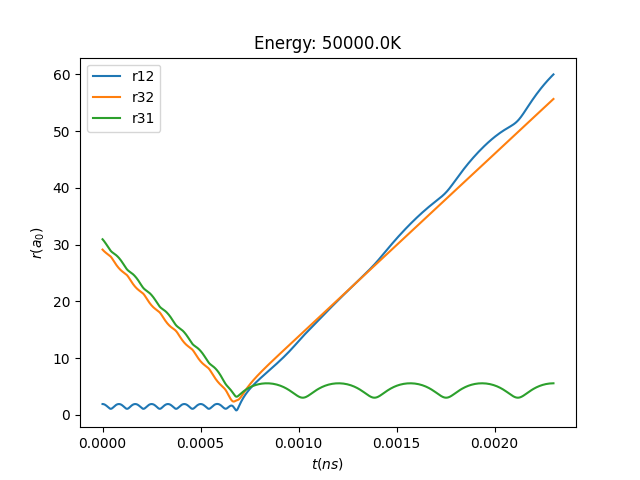

In [63]:
fig,ax = plt.subplots()
plotters.traj_plt(reac, ax)

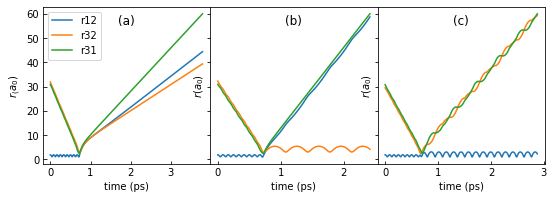

In [7]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize = (9,3))
plotters.traj_plt(diss, axs[0], title=False)
plotters.traj_plt(reac, axs[1], title=False, legend = False)
plotters.traj_plt(quench, axs[2], title=False, legend = False)
plt.subplots_adjust(wspace=0, bottom = 0.15)
axs[0].set_title('(a)', x= .5, y = .85)
axs[1].set_title('(b)', x= .5, y = .85)
axs[2].set_title('(c)', x= .5, y = .85)
axs[1].set_xlabel('time (ps)')
axs[2].set_xlabel('time (ps)')
axs[0].set_xlabel('time (ps)')
axs[0].set_ylabel('$r_(a_0)$')
axs[0].tick_params(axis = 'x', direction = 'in')
axs[1].tick_params(axis = 'x', direction = 'in')
axs[2].tick_params(axis = 'x', direction = 'in')
axs[0].tick_params(axis = 'y', direction = 'in')
# plt.show()
# plt.tight_layout(w_pad=-.3)
# fig.supxlabel('time (a.u.)', fontsize = 12)
# fig.supylabel('$r_(a_0)$', fontsize = 12, ha = 'left')
# fig.savefig('../results/comm_figs/traj.pdf')

Trace the path through time.

In [37]:
ax1 = plotters.traj_3d(diss)
plt.show(ax1)

Make a 3d

<IPython.core.display.Javascript object>


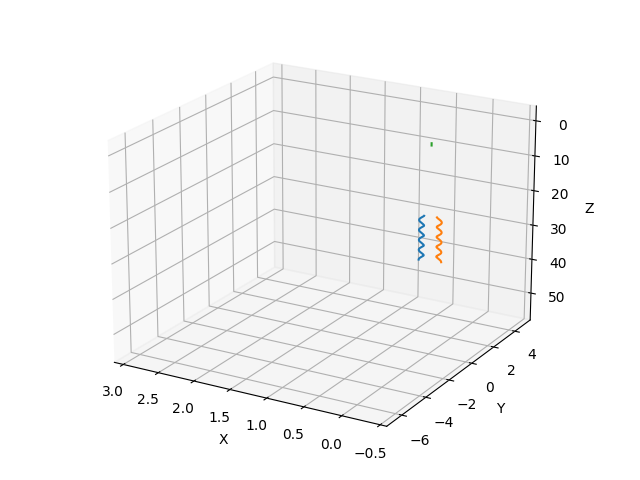

TypeError: plot() missing 1 required positional argument: 'ys'

In [38]:
ax = plotters.traj_gif(reac)
plt.plot(ax)

# Parallel Run
For the same (Ec,b), run 'n_traj' number of trajectories, and save to 'dir/output.csv' file.

In [ ]:
n_traj = 13
dir = 'example/'
output = f'test.csv'
cpus = mp.cpu_count()
bvals = np.arange(0,5,1)
calc = pymar.start('inputs.json') # Create QCT calculation inputs (Energy spectrum, turning points, etc.)
result = []

t1 = time.time()
with mp.Pool(processes = cpus) as p:
    event = [p.apply_async(pymar.main, kwds = (calc)) for i in range(n_traj)]
    for j,res in enumerate(event):
        result.append(res.get()) # Comment out if long output required
        # df = pd.DataFrame([res.get()]) # Comment out if short output required
        # df.to_csv(f'{dir}{output}', mode='a' ,index=False, header=( j == 0)) # Comment out if short output required
print(f'{time.time() - t1}')


14.969618082046509


In [ ]:
df = pd.DataFrame(result)
counts = df.iloc[:,:6].groupby(['e','b']).sum()
counts

,,h2,cah1,cah2,diss
e,b,,,,
30000.0,0,12,1,0,0


## Analyzing the data
Use pandas DataFrames to find the cross section or rates of the reaction CaH. Use the larger dataset to see meaningful results.

In [26]:
# Define system parameters
m1,m2,m3 = data['masses'].values()
mtot = m1 + m2 + m3
mu12 = m1*m2/(m1+m2) # H2
mu31 = m1*m3/(m1+m3) # CaH
mu32 = m2*m3/(m2+m3) # CaH
mu123 = m3*(m1+m2)/mtot

In [19]:
df = pd.read_csv('data/fv0j0.csv')
df = df[df['v'] >= 0]
stats = df.iloc[:,:7].groupby(['e','b']).sum()
weights = df.drop(df.iloc[:,9:], axis=1)
nt = stats.sum(axis=1) # Total number of trajectories for a given (E,b)

In [20]:
# Define weights 
is_cah1 = df['cah1'] == 1 
is_cah2 = df['cah2'] == 1
is_cah = is_cah1 | is_cah2
cah_w = weights[is_cah].groupby(['e','b','v']).sum()
h2_w = weights[weights['h2']==1].groupby(['e','b','v']).sum()
d_w = weights[weights['d'] == 1].groupby(['e','b','v']).sum()
# Net weight should be summed over all v' values, 
# with the number of dissociation results added.
net_w = weights.groupby(['e','b']).sum()
net_w['w'] += net_w['d']

<IPython.core.display.Javascript object>


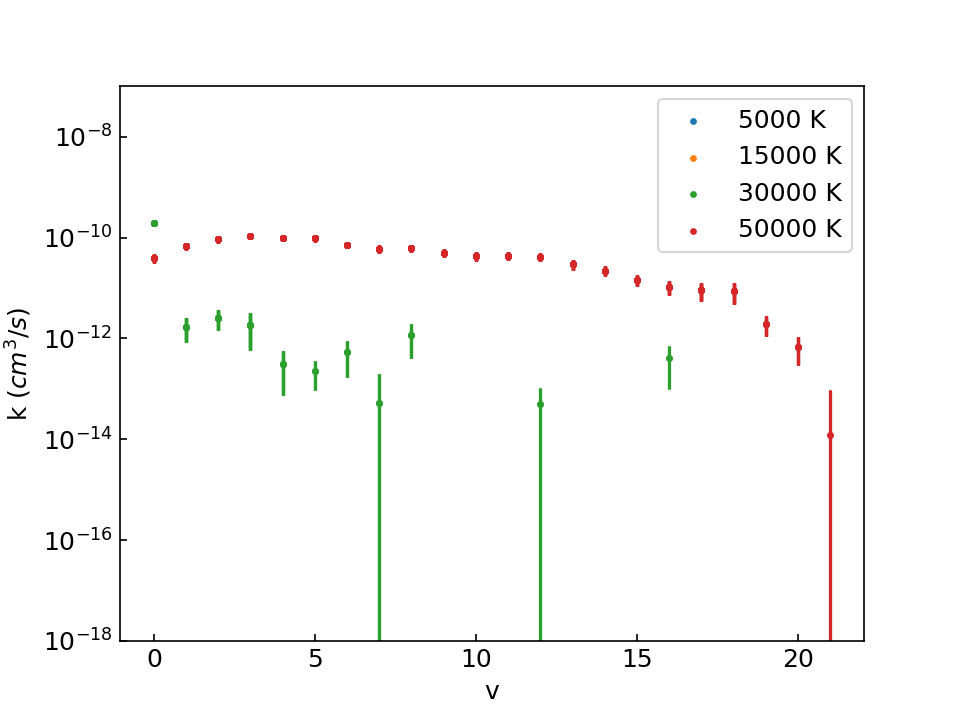

Text(0, 0.5, 'k $(cm^3/s)$')

In [27]:
# DISTRIBUTIONS
cah = df[is_cah].groupby(['e','b','v']).sum()
cah['p_r'] = cah_w['w']/net_w['w'] # Probability of reaction P(E,b,v)
cah['perr_r'] = np.sqrt(cah_w['w'])/net_w['w']*np.sqrt((net_w['w']-cah_w['w'])/net_w['w'])
### Calculate cross section & rates ### 
cah = cah.reset_index() # Drop dependence on b to integrate
cah.set_index(['e','v'], inplace=True)
cah['s'] = cah.groupby(['e','v']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.p_r*g.b, x=g.b))
cah['s_err'] = cah.groupby(['e','v']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.perr_r*g.b, x=g.b))
cah['k'] = np.sqrt(2*3/2*constants.kb*cah['s'].index.get_level_values(level = 'e')/mu123)*cah['s']*constants.autocm**3/constants.ttos
cah['k_err'] = np.sqrt(2*3/2*constants.kb*cah['s_err'].index.get_level_values(level = 'e')/mu123)*cah['s_err']*constants.autocm**3/constants.ttos

### Plot rate ###
cah = cah.reset_index()
evals = cah.e.unique()
evals = [5000,15000,30000, 50000]
plt.rcParams.update({'font.size':12})
plt.rc('axes', labelsize = 12)
ax = cah[cah['e']==evals[0]].plot.scatter(x='v',y='k', yerr = 'k_err', marker ='.', label = f'{evals[0]} K')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for idx,e in enumerate(evals[1:]): 
    idx += 1
    cah[cah['e']==e].plot.scatter(x='v',y='k', yerr = 'k_err', marker ='.', label = f'{e} K', c = colors[idx], ax=ax)
ax.tick_params(axis = 'x', direction = 'in')
ax.tick_params(axis = 'y', direction = 'in')
# plt.legend(bbox_to_anchor = (1,1))
plt.yscale('log')
plt.ylim(10e-19,10e-8)
plt.ylabel('k $(cm^3/s)$')
# plt.title('CaH Formation Rate Distribution ($v_i = 1$)')
# plt.savefig('results/comm_figs/cah_dist_over.svg')


## Inspect the effect of $v_i$ on CaH formation

In [29]:
df0 = pd.read_csv('data/fv0j0.csv')
df1 = pd.read_csv('data/fv1j0.csv')
df2 = pd.read_csv('data/fv2j0.csv')

In [30]:
df = pd.concat([df0,df1,df2])
df = df[df['v'] >= 0]
df = df.set_index('n_i')
stats = df.groupby(['e','b']).sum().iloc[:,:7]
weights = df.drop(df.iloc[:,9:], axis=1)
nt = stats.sum(axis=1) # Total number of trajectories for a given (E,b)

In [31]:
# Define weights 
is_cah1 = df['cah1'] == 1 
is_cah2 = df['cah2'] == 1
is_cah = is_cah1 | is_cah2
cah_w = weights[is_cah].groupby(['n_i','e','b','v']).sum()
h2_w = weights[weights['h2']==1].groupby(['n_i','e','b','v']).sum()
d_w = weights[weights['d'] == 1].groupby(['n_i','e','b','v']).sum()
# Net weight should be summed over all v' values, 
# with the number of dissociation results added.
net_w = weights.groupby(['n_i','e','b']).sum()
net_w['w'] += net_w['d']

In [32]:
# DISTRIBUTIONS
cah = df[is_cah].groupby(['n_i','e','b','v']).sum()
cah['p_r'] = cah_w['w']/net_w['w'] # Probability of reaction P(E,b,v)
cah['perr_r'] = np.sqrt(cah_w['w'])/net_w['w']*np.sqrt((net_w['w']-cah_w['w'])/net_w['w'])
### Calculate cross section & rates ### 
cah = cah.reset_index(level = 2) # Drop dependence on b to integrate
# cah.set_index(['n_i','e','v'], inplace=True)
cah['s'] = cah.groupby(['n_i','e','v']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.p_r*g.b, x=g.b))
cah['s_err'] = cah.groupby(['n_i','e','v']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.perr_r*g.b, x=g.b))
cah['k'] = np.sqrt(2*3/2*constants.kb*cah['s'].index.get_level_values(level = 'e')/mu123)*cah['s']*constants.autocm**3/constants.ttos
cah['k_err'] = np.sqrt(2*3/2*constants.kb*cah['s_err'].index.get_level_values(level = 'e')/mu123)*cah['s_err']*constants.autocm**3/constants.ttos

<IPython.core.display.Javascript object>


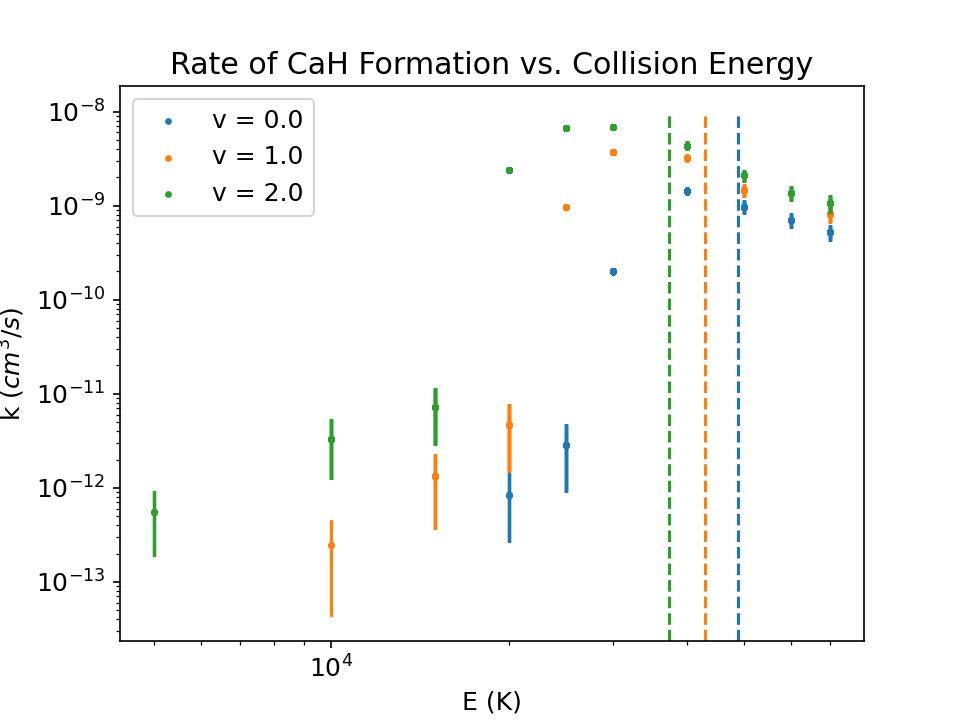

Text(0, 0.5, 'k ($cm^3/s$)')

In [33]:
# Calculate P(E,b), sigma(E), k(E) #
# Sum over v's
cah_eb = cah.reset_index().groupby(['n_i','e','b']).sum()
cah_eb = cah_eb.reset_index(level = 2) # Drop dependence on b to integrate
cah_eb['s(e)'] = cah_eb.groupby(['n_i','e']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.p_r*g.b, x=g.b))
cah_eb['s_err(e)'] = cah_eb.groupby(['n_i','e']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.perr_r*g.b, x=g.b))
cah_eb['k(e)'] = np.sqrt(2*3/2*constants.kb*cah_eb['s(e)'].index.get_level_values(level = 'e')/mu123)*cah_eb['s(e)']*constants.autocm**3/constants.ttos
cah_eb['k_err(e)'] = np.sqrt(2*3/2*constants.kb*cah_eb['s_err(e)'].index.get_level_values(level = 'e')/mu123)*cah_eb['s_err(e)']*constants.autocm**3/constants.ttos
cah_eb['s(e)'] = cah_eb['s(e)'].drop_duplicates()
cah_eb = cah_eb.reset_index()
elev = cah_eb.n_i.unique()
di = [0.15468234,0.13583315,0.11820821, 0.10180754, 0.08663113]
ax = cah_eb[cah_eb['n_i']==0].plot.scatter(x='e',y='k(e)', yerr= 'k_err(e)', marker = '.', label = f'v = {elev[0]}')
plt.vlines(di[0]/constants.cEK2H, 0, 1e-8, linestyles='dashed')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for idx,v in enumerate(elev[1:]):
    idx += 1
    cah_eb[cah_eb['n_i']==v].plot.scatter(x = 'e', y = 'k(e)', yerr = 'k_err(e)', marker = '.', label = f'v = {v}', color = colors[idx], ax=ax)
    plt.vlines(di[idx]/constants.cEK2H, 0, 1e-8, linestyles='dashed', color = colors[idx])
plt.xscale('log')
plt.yscale('log')
plt.title('Rate of CaH Formation vs. Collision Energy')
plt.xlabel('E (K)')
plt.ylabel('k ($cm^3/s$)')